In [ ]:
import os # os: 운영체제와 상호작용하기 위한 모듈
import numpy as np # numpy(np): 과학적 계산을 위한 라이브러리로 배열, 행렬 계산에 특화됨
import pandas as pd # pandas(pd): 데이터 조작을 위한 라이브러리로 테이블 데이터 조작, 분석에 특화됨
import ast # ast: Abstract Syntax Trees을 다루는 모듈로, 문자열을 파이썬 코드로 변환하는 등 다양한 기능을 제공
import torch # torch: PyTorch 딥러닝 프레임워크의 핵심 모듈로 딥러닝 모델을 정의, 학습, 실행하는 기능을 제공
import PIL # PIL: 이미지 처리를 위한 라이브러리
from tqdm.auto import tqdm # tqdm: for 루프의 진행 상황을 시각화하여 보여주는 라이브러리
import shutil as sh # shutil(sh): 파일 및 폴더 작업을 위한 라이브러리
from pathlib import Path # pathlib: 파일 경로 다루기 위한 라이브러리
import random # random: 난수 생성 및 셔플링 등 다양한 무작위 작업을 위한 라이브러리


# IPython.display: Jupyter Notebook 등의 인터랙티브한 환경에서 디스플레이와 관련된 기능을 제공하는 모듈
# Image: 이미지를 보여주는 함수
# clear_output: 출력 셀의 내용을 지우는 함수
from IPython.display import Image, clear_output 

import matplotlib.pyplot as plt # matplotlib.pyplot(plt): 데이터 시각화를 위한 라이브러리
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## YOLOv8 Installation
- YOLOv8의 설치는 매우 쉽습니다. `!pip` 명령으로 설치할 수 있는 Python 모듈입니다. 
- `!yolo checks` 명령은 설치된 버전, Python 및 PyTorch 버전에 대한 정보를 표시하고 하드웨어에 대한 정보를 표시합니다. 
- 즉, GPU 카드, CPU 수, RAM 및 디스크 공간, 새로운 YOLOv8 모델 학습에 대한 모든 중요한 정보입니다.

In [ ]:
# Pip install (recommended)
!pip install ultralytics

from IPython import display
display.clear_output()
!yolo checks

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 25.4/166.8 GB disk)


Albummentation은 이미지 확대를 위한 훌륭한 라이브러리이며 특히 위성 이미지를 잘 처리하는 라이브러리입니다.

In [ ]:
# Updating Kaggle notebook version of albumentations
!pip install albumentations==1.0.3
display.clear_output()
!pip show albumentations

Name: albumentations
Version: 1.0.3
Summary: Fast image augmentation library and easy to use wrapper around other libraries
Home-page: https://github.com/albumentations-team/albumentations
Author: Buslaev Alexander, Alexander Parinov, Vladimir Iglovikov, Eugene Khvedchenya, Druzhinin Mikhail
Author-email: 
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: numpy, opencv-python-headless, PyYAML, scikit-image, scipy
Required-by: 


##Airbus Aircraft Dataset (sample)
- 일반적으로 위성 이미지는 꽤 큽니다. 예를 들어 Pleiades 이미지는 20km x 20km의 영역을 다루고 40,000 x 40,000 픽셀을 특징으로 합니다. 데이터 세트에는 이러한 위성 획득의 추출물만 있습니다. 이미지는 2560 x 2560 픽셀로 GPU에 동시에 많은 이미지를 담기에는 여전히 너무 큽니다(GPU는 15GB RAM임을 기억하십시오).

- 여기서 우리가 해야 할 일은 이미지를 더 작은 덩어리, 예를 들어 512 x 512 픽셀로 타일링하는 것입니다. 타일 경계에서 개체를 자르면 전체 개체가 포함된 다른 타일을 얻을 수 있도록 겹침으로 이 작업을 수행합니다. 타일링 프로세스에 대해서는 자세히 다루지 않겠습니다. 이전 기사를 참조하거나 소스 코드를 살펴보십시오.

- 하지만 언급할 가치가 있는 한 가지 사실은 우리가 타일링(겹침이 있거나 없는)을 수행하는 경우 동일한 소스 이미지에서 오는 모든 타일이 동일한 분할(즉, 교육 또는 유효성 검사)에 있는지 확인하고자 한다는 사실입니다. 검증 데이터 세트를 사용하여 교육이 새로운 위성 이미지에서 잘 수행되는 모델을 제공하는지 확인하려고 합니다. 따라서 교육 및 검증 세트에 동일한 소스 이미지의 타일이 포함되지 않도록 해야 합니다.

In [ ]:
#현재 폴더 경로 위치 확인 방법
%pwd 

'/content'

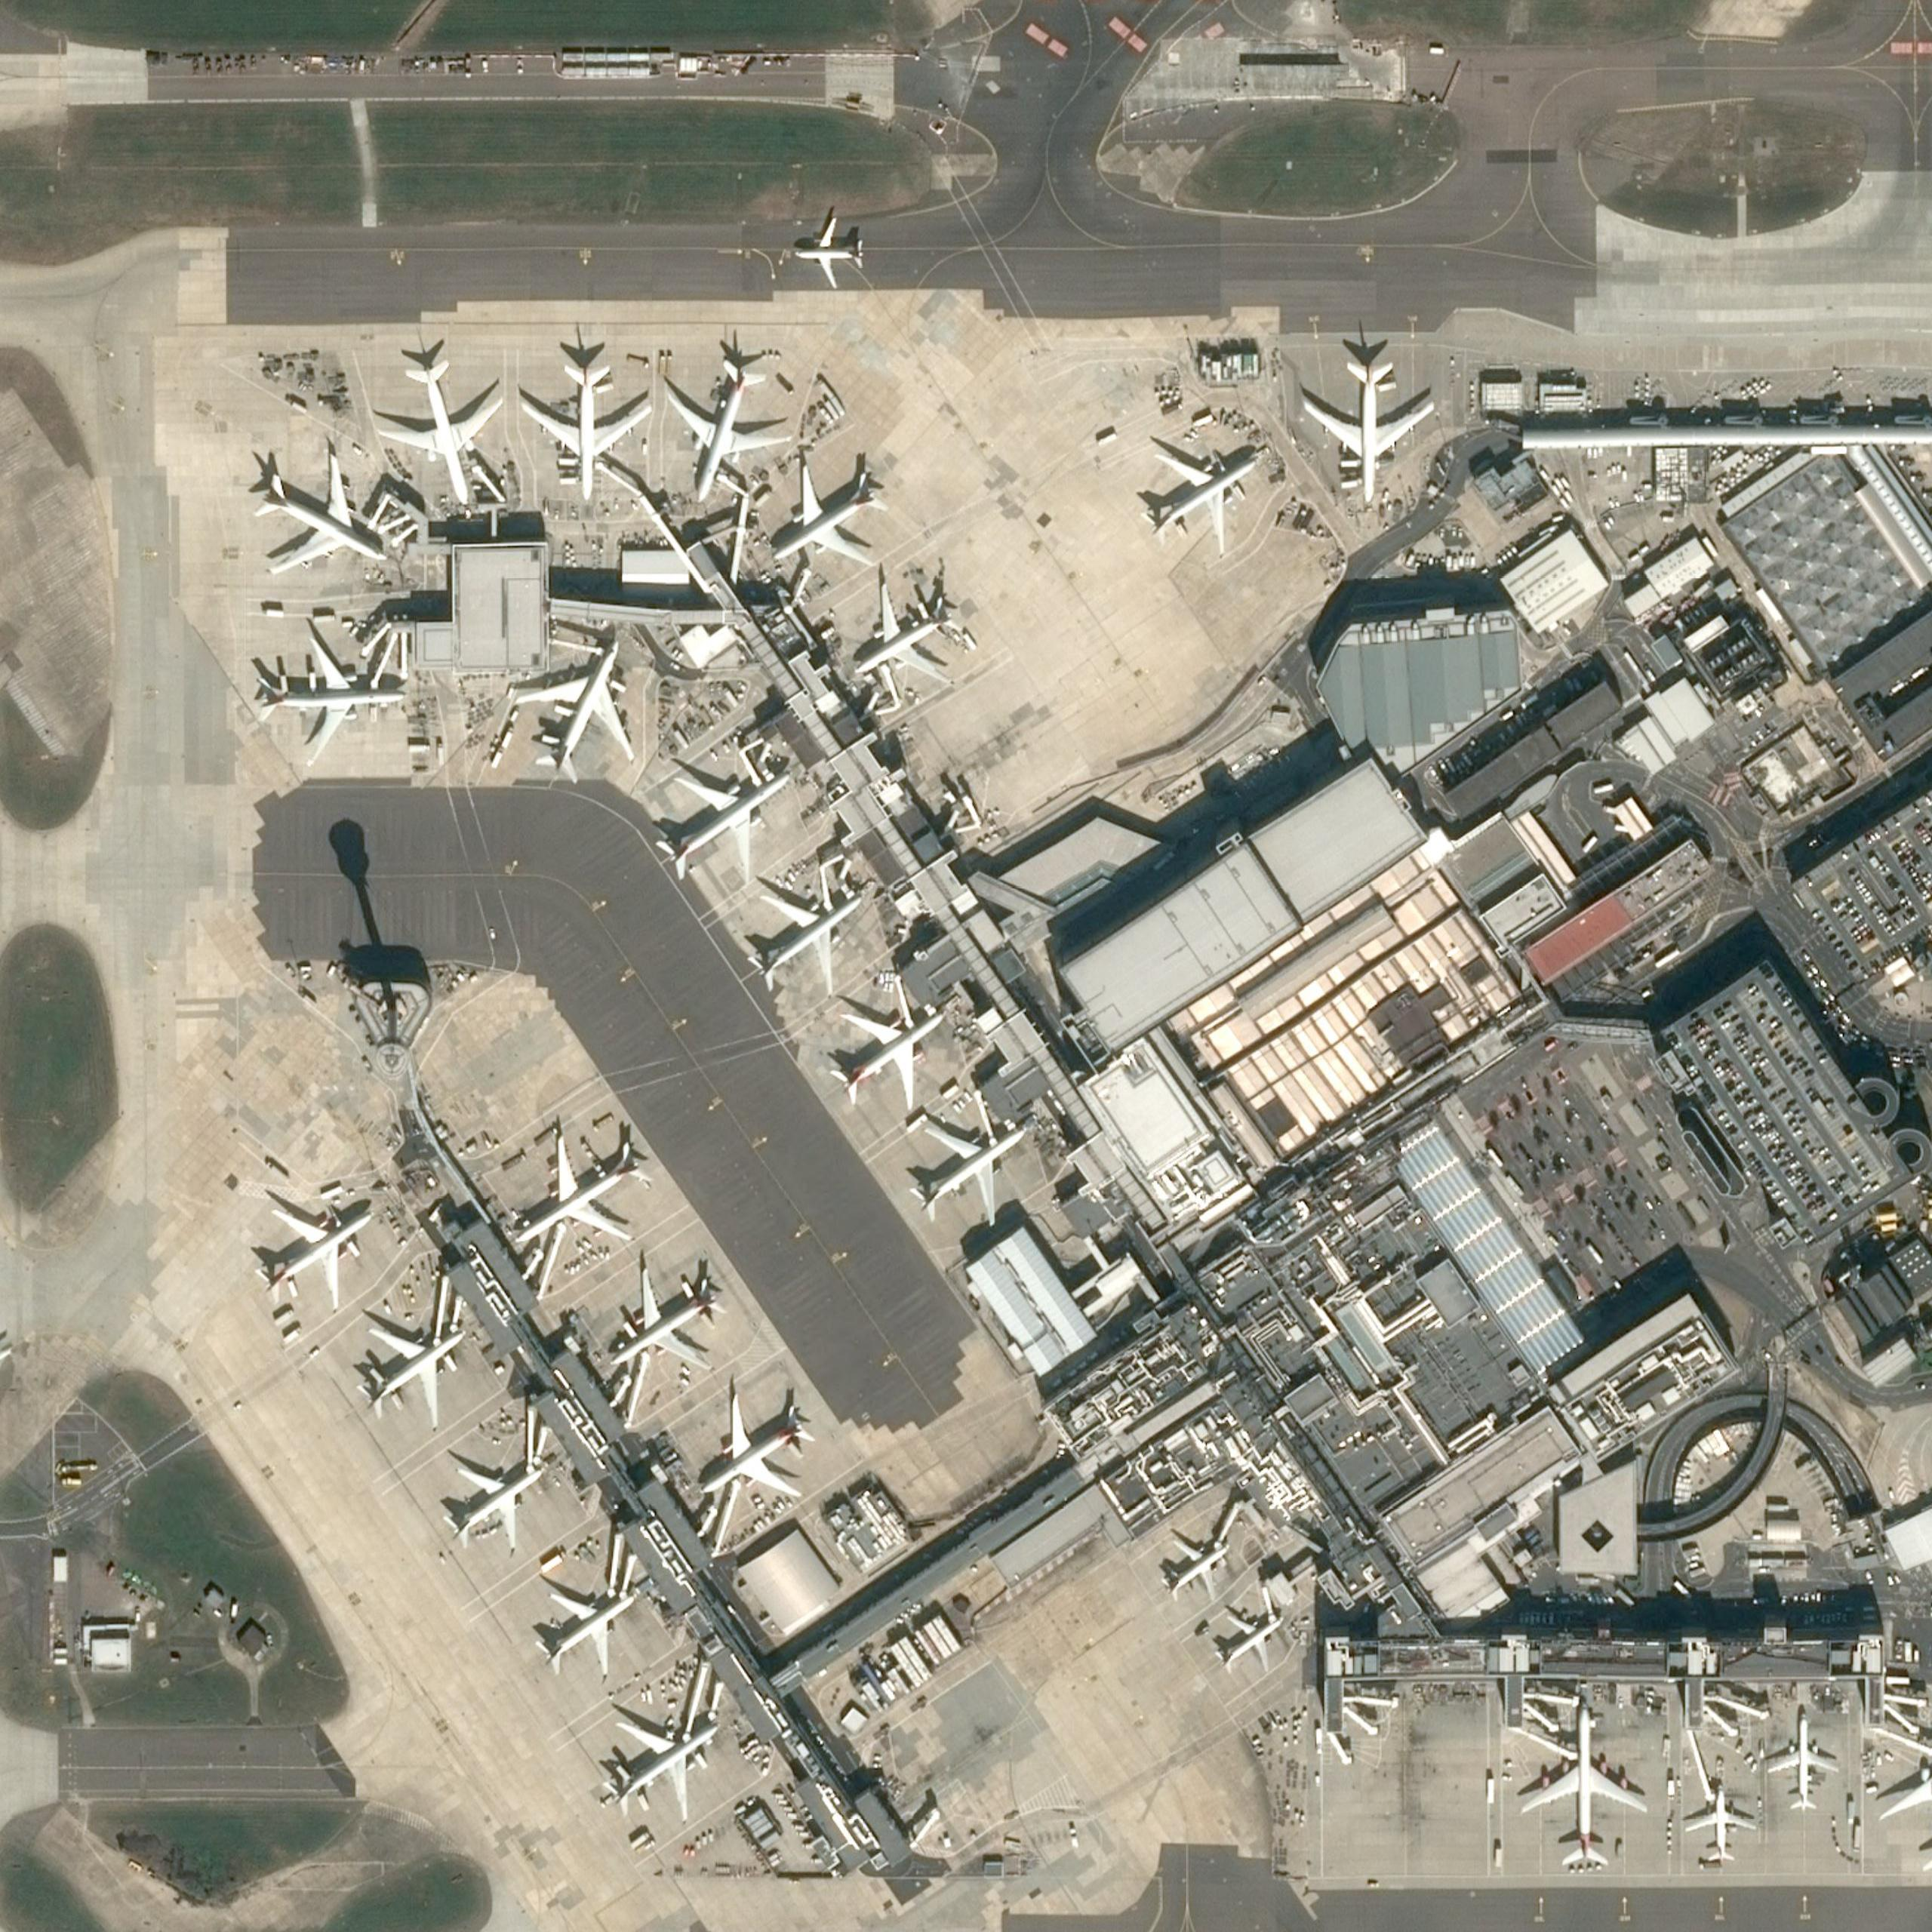

In [ ]:
# Display one random image from the dataset
DATA_DIR = Path('/content/drive/MyDrive/airbus-aircrafts-sample-dataset') # 주소확인중요!
img_list = list(DATA_DIR.glob('images/*.jpg'))
pickone = random.choice(img_list)
display.Image(pickone)

### Dataset analysis
- 데이터 세트에는 학습용 이미지 103개와 평가용 추가 이미지 6개(제공된 주석 없음)가 포함되어 있습니다. 
- 이미지는 실제로 JPEG 형식의 RGB(3밴드) 2560픽셀 x 2560픽셀 이미지입니다.
- 주석은 이미지, 닫힌 다각형으로서의 형상 및 클래스를 참조하는 CSV 파일로 제공됩니다. 
- 이미지 경계에서 잘린 항공기를 포함하여 항공기에 대한 3,425개의 주석이 있습니다.

In [ ]:
'''
해당 코드는 선택된 이미지 파일의 크기와 채널 수를 출력하는 코드입니다.
'''

print(f"Found {len(img_list)} images files in {DATA_DIR}") # 데이터셋 경로에서 '*.jpg' 확장자를 가진 이미지 파일들의 수를 출력합니다.

img = PIL.Image.open(pickone) # 선택된 이미지 파일을 PIL.Image.open() 함수를 이용해 img 객체에 저장합니다.
IMAGE_HEIGHT, IMAGE_WIDTH = img.size # img 객체의 크기를 가져와서 IMAGE_HEIGHT, IMAGE_WIDTH 변수에 각각 저장합니다.
num_channels = len(img.mode) # img 객체의 채널 수를 가져와 num_channels 변수에 저장합니다.
print("Image size: {}".format((IMAGE_HEIGHT, IMAGE_WIDTH))) # 선택된 이미지 파일의 크기를 출력합니다.
print("Num channels: {}".format(num_channels)) #선택된 이미지 파일의 채널 수를 출력합니다.

Found 103 images files in /content/drive/MyDrive/airbus-aircrafts-sample-dataset
Image size: (2560, 2560)
Num channels: 3


## Airbus data pre-processing

In [ ]:
# convert a string record into a valid python object

# ast.literal_eval() 함수를 이용하여 문자열로 저장된 데이터를 유효한 파이썬 객체로 변환하는 함수 f(x)를 정의합니다.
def f(x): 
    return ast.literal_eval(x.rstrip('\r\n'))


# DATA_DIR 디렉토리에 저장된 'annotations.csv' 파일을 pandas의 read_csv() 함수를 이용하여 읽어들입니다. 
# converters 인자를 이용하여 'geometry' 열의 데이터는 f() 함수를 통해 파이썬 객체로 변환하고, 
# 'class' 열의 모든 데이터는 'Aircraft'로 변환합니다.
df = pd.read_csv(DATA_DIR / "annotations.csv", 
                converters={'geometry': f, 'class': lambda o: 'Aircraft'})

df.head(10) #읽어들인 데이터프레임의 첫 10개 행을 출력합니다.

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Aircraft
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Aircraft
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Aircraft
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Aircraft
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Aircraft
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Aircraft
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Aircraft
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Aircraft
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Aircraft
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Aircraft


In [ ]:
'''
해당 코드는 데이터프레임에 'bounds', 'width', 'height' 열을 추가하는 코드입니다. 
'bounds'는 geometry 열의 좌표 정보를 이용하여,
 해당 object의 bounding box를 나타내는 (xmin, ymin, xmax, ymax) 형식의 튜플을 계산합니다. 
'width'와 'height'는 'bounds'에서 계산된 값을 이용하여 해당 object의 너비와 높이를 계산합니다.
'''

# geometry 열의 좌표 정보를 이용하여 bounding box를 계산하는 함수 getBounds(geometry)를 정의합니다.
def getBounds(geometry):
    try: 
        arr = np.array(geometry).T
        xmin = np.min(arr[0])
        ymin = np.min(arr[1])
        xmax = np.max(arr[0])
        ymax = np.max(arr[1])
        return (xmin, ymin, xmax, ymax)
    except:
        return np.nan

# 'bounds' 튜플에서 object의 너비를 계산하는 함수 getWidth(bounds)를 정의합니다.
def getWidth(bounds):
    try: 
        (xmin, ymin, xmax, ymax) = bounds
        return np.abs(xmax - xmin)
    except:
        return np.nan

# 'bounds' 튜플에서 object의 높이를 계산하는 함수 getHeight(bounds)를 정의합니다.
def getHeight(bounds):
    try: 
        (xmin, ymin, xmax, ymax) = bounds
        return np.abs(ymax - ymin)
    except:
        return np.nan



# Create bounds, width and height
df.loc[:,'bounds'] = df.loc[:,'geometry'].apply(getBounds) # 'geometry' 열의 모든 행에 대해서 getBounds() 함수를 적용하여 'bounds' 열을 추가합니다.
df.loc[:,'width'] = df.loc[:,'bounds'].apply(getWidth) # 'bounds' 열의 모든 행에 대해서 getWidth() 함수를 적용하여 'width' 열을 추가합니다.
df.loc[:,'height'] = df.loc[:,'bounds'].apply(getHeight) # 'bounds' 열의 모든 행에 대해서 getHeight() 함수를 적용하여 'height' 열을 추가합니다.
df.head(10)

,id,image_id,geometry,class,bounds,width,height
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Aircraft,"(135, 522, 245, 600)",110,78
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Aircraft,"(1025, 284, 1125, 384)",100,100
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Aircraft,"(1058, 1503, 1130, 1568)",72,65
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Aircraft,"(813, 1518, 885, 1604)",72,86
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Aircraft,"(594, 938, 657, 1012)",63,74
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Aircraft,"(451, 725, 524, 798)",73,73
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Aircraft,"(1543, 1437, 1614, 1497)",71,60
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Aircraft,"(1485, 1370, 1561, 1437)",76,67
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Aircraft,"(1968, 1624, 2053, 1687)",85,63
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Aircraft,"(1659, 1674, 1733, 1746)",74,72


In [ ]:
'''
해당 코드는 데이터셋을 k-fold 교차검증(k-fold cross validation)을 하기 위해, 
현재 코드에서는 fold=1이라는 하나의 fold에 대한 검증 데이터셋을 만들기 위해 
필요한 이미지 파일들의 리스트를 생성하는 코드입니다.
해당 코드는 fold=1일 때 전체 데이터셋 중 1/5 부분을 검증 데이터셋으로 사용하도록 하고 있습니다.
'''
# create a list of images used for validation
# this list is the same as in the previous notebook on YOLOv5

fold = 1 # 하나의 fold에 대한 검증 데이터셋을 만들기 위해, fold를 1로 설정합니다.
num_fold = 5 # 전체 데이터셋을 5개 fold로 나누어 교차검증을 수행합니다.
index = df['image_id'].unique() # 데이터프레임에서 중복을 제거한 unique한 image_id 값을 index 리스트에 저장합니다.

#리스트에서 현재 fold의 검증 데이터셋에 해당하는 image_id 값을 추출하여 val_indexes 리스트에 저장합니다. 
val_indexes = index[len(index)*fold//num_fold:len(index)*(fold+1)//num_fold]

print(val_indexes)


['78099b50-f2b6-4319-b462-f33df2966c45.jpg'
 '22291e0b-ebe2-4f3f-b53e-4e709179300a.jpg'
 'cc4f3226-c262-409e-a4b2-a576e776f7f4.jpg'
 '34ae857d-6e71-46b9-b694-d9e40fb093bc.jpg'
 '5c9e817a-dc4b-42ab-952c-3128e2de12e8.jpg'
 'af67041b-f363-47ae-8ddd-f652db3a6bab.jpg'
 '0263270b-e3ee-41dc-aeef-43ff77e66d5b.jpg'
 'd8873734-016a-4b9d-9b9e-8bc47eb13fef.jpg'
 'd0c3d270-f23e-4792-bac0-142a9cc8ccc6.jpg'
 '78400c58-1a7c-4342-a1fb-2117cb7cbc8b.jpg'
 '77f7b57f-5cf2-424d-a952-9847b3c3f35e.jpg'
 'd9399a45-6745-4e59-8903-90640b2ddf9f.jpg'
 '014de911-7810-4f7d-8967-3e5402209f4a.jpg'
 'd3d2b706-9017-41f4-b57e-469038daa634.jpg'
 '4c9d2482-788c-4d68-a3d4-478b2367abce.jpg'
 '576827bc-a94a-4611-8820-f3d56e969151.jpg'
 '4e9164aa-532e-4b76-bce4-060b090da357.jpg'
 '14436c8c-93ec-41af-9fbf-43a5f39f2b98.jpg'
 '7635d63c-6b97-4c9c-a7dc-27773d42ed4c.jpg'
 'ecfe7982-05e5-435f-824b-e24b6846316e.jpg'
 '8df07836-4606-446e-9880-6ed9e0f74543.jpg']


In [ ]:
'''
해당 코드는 데이터셋 이미지를 512x512 크기의 타일로 잘라내고, 각 타일에 대한 라벨 정보를 텍스트 파일로 저장하는 코드입니다.
'''

import os 
import tqdm.notebook

# Create 512x512 tiles with 64 pix overlap in directory '/kaggle/working'

# 생성할 타일의 크기와 각 타일간의 overlap 크기를 설정합니다.
TILE_WIDTH = 512
TILE_HEIGHT = 512
TILE_OVERLAP = 64


# 타일 안에 포함되지 않은 라벨 정보에 대해 해당 라벨이 잘린 비율(truncated percent)을 설정합니다.
TRUNCATED_PERCENT = 0.3


#타일 이미지 파일을 생성할 때, 이미 파일이 존재하는 경우에 대한 동작 방식을 설정하는 변수입니다. 
#해당 변수가 True로 설정된 경우, 이미 존재하는 타일 이미지 파일을 덮어쓰게 됩니다. 
#False로 설정된 경우, 이미 존재하는 타일 이미지 파일을 건너뛰게 됩니다.
_overwriteFiles = True


#TILES_DIR
#타일 이미지 파일을 저장할 경로를 지정합니다. 'train'과 'val' 두 가지 폴더가 존재하며, 
#각각의 폴더는 Path 클래스를 이용하여 '/kaggle/working/train/images/'와 '/kaggle/working/val/images/' 경로를 지정합니다. 
#이는 Kaggle의 작업 디렉토리에서 train/images 폴더와 val/images 폴더를 생성하여 타일 이미지 파일을 저장하게 됩니다.
TILES_DIR = {'train': Path('/kaggle/working/train/images/'),
             'val': Path('/kaggle/working/val/images/')}
for _, folder in TILES_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)


#LABELS_DIR: 라벨 정보 텍스트 파일을 저장할 경로를 지정합니다. 'train'과 'val' 두 가지 폴더가 존재하며, 
#각각의 폴더는 Path 클래스를 이용하여 '/kaggle/working/train/labels/'와 '/kaggle/working/val/labels/' 경로를 지정합니다. 
#이는 Kaggle의 작업 디렉토리에서 train/labels 폴더와 val/labels 폴더를 생성하여 라벨 정보 텍스트 파일을 저장하게 됩니다.
LABELS_DIR = {'train': Path('/kaggle/working/train/labels/'),
              'val': Path('/kaggle/working/val/labels/')}
for _, folder in LABELS_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)
#if not os.path.isdir(folder): 해당 경로가 디렉토리인지 아닌지를 판별하고, 
#디렉토리가 아니라면 해당 경로를 생성합니다. 
#이를 통해 이미 생성되어 있는 경로는 건너뛰고, 없는 경로만 생성하게 됩니다.

In [ ]:
'''

입력된 bounds(바운딩 박스) 정보와 
타일 이미지의 x_start, y_start, width, height, truncated_percent 값을 이용하여
해당 타일 안에 포함되는 라벨 정보를 반환하는 함수입니다.

-- bounds: 바운딩 박스 정보로, [xmin, ymin, xmax, ymax]의 형태로 구성된 리스트입니다.
-- x_start, y_start: 타일 이미지의 좌측 상단 꼭지점의 x, y 좌표값입니다.
-- width, height: 타일 이미지의 가로, 세로 크기입니다.
-- truncated_percent: 해당 라벨이 잘리는 비율의 한계값을 의미합니다.

이 함수는 위의 인자들을 이용하여, 
바운딩 박스가 해당 타일 안에 포함되지 않거나(truncated_percent 값을 초과하는 비율로 잘렸을 경우), 
비어 있는 값을 반환합니다. 
이외에는 중심 좌표와 상대 크기(x_extend, y_extend) 값을 반환하게 됩니다.

'''

# Save one line in .txt file for each tag found inside the tile
def tag_is_inside_tile(bounds, x_start, y_start, width, height, truncated_percent):
    x_min, y_min, x_max, y_max = bounds
    x_min, y_min, x_max, y_max = x_min - x_start, y_min - y_start, x_max - x_start, y_max - y_start

    if (x_min > width) or (x_max < 0.0) or (y_min > height) or (y_max < 0.0):
        return None
    
    x_max_trunc = min(x_max, width) 
    x_min_trunc = max(x_min, 0) 
    if (x_max_trunc - x_min_trunc) / (x_max - x_min) < truncated_percent:
        return None

    y_max_trunc = min(y_max, width) 
    y_min_trunc = max(y_min, 0) 
    if (y_max_trunc - y_min_trunc) / (y_max - y_min) < truncated_percent:
        return None
        
    x_center = (x_min_trunc + x_max_trunc) / 2.0 / width
    y_center = (y_min_trunc + y_max_trunc) / 2.0 / height
    x_extend = (x_max_trunc - x_min_trunc) / width
    y_extend = (y_max_trunc - y_min_trunc) / height
    
    return (0, x_center, y_center, x_extend, y_extend)
            

In [ ]:
'''
위 코드는 먼저 원본 이미지를 512 x 512 타일로 잘라내는 작업을 수행합니다. 
타일간에는 TILE_OVERLAP 만큼의 겹침이 있으며, 잘린 타일 이미지는 /kaggle/working/train/images/ 또는 /kaggle/working/val/images/ 폴더에 저장됩니다.

각 타일 이미지와 매핑되는 라벨 정보는 /kaggle/working/train/labels/ 또는 /kaggle/working/val/labels/ 폴더에 저장됩니다. 
라벨 파일의 이름은 잘린 타일 이미지 파일의 이름과 같으며, 확장자는 txt입니다.

라벨 파일 내에서는 각 라벨 정보가 한 줄에 하나씩 적혀 있습니다. 
라벨 정보는 YOLO 포맷과 같으며, [class_id, x_center, y_center, width, height] 형태로 저장됩니다.

class_id 는 라벨링된 객체의 클래스를 나타내며,
x_center, y_center, width, height는 해당 객체의 위치와 크기를 정규화된 좌표로 표현한 것입니다.
'''



for img_path in tqdm.notebook.tqdm(img_list):
    # Open image and related data
    pil_img = PIL.Image.open(img_path, mode='r')
    np_img = np.array(pil_img, dtype=np.uint8)

    # Get annotations for image
    img_labels = df[df["image_id"] == img_path.name]
    #print(img_labels)

    # Count number of sections to make
    X_TILES = (IMAGE_WIDTH + TILE_WIDTH - TILE_OVERLAP - 1) // (TILE_WIDTH - TILE_OVERLAP)
    Y_TILES = (IMAGE_HEIGHT + TILE_HEIGHT - TILE_OVERLAP - 1) // (TILE_HEIGHT - TILE_OVERLAP)
    
    # Cut each tile
    for x in range(X_TILES):
        for y in range(Y_TILES):

            x_end = min((x + 1) * TILE_WIDTH - TILE_OVERLAP * (x != 0), IMAGE_WIDTH)
            x_start = x_end - TILE_WIDTH
            y_end = min((y + 1) * TILE_HEIGHT - TILE_OVERLAP * (y != 0), IMAGE_HEIGHT)
            y_start = y_end - TILE_HEIGHT
            #print(x_start, y_start)

            folder = 'val' if img_path.name in val_indexes else 'train'
            save_tile_path = TILES_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".jpg")
            save_label_path = LABELS_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".txt")
                
            # Save if file doesn't exit
            if _overwriteFiles or not os.path.isfile(save_tile_path):
                cut_tile = np.zeros(shape=(TILE_WIDTH, TILE_HEIGHT, 3), dtype=np.uint8)
                cut_tile[0:TILE_HEIGHT, 0:TILE_WIDTH, :] = np_img[y_start:y_end, x_start:x_end, :]
                cut_tile_img = PIL.Image.fromarray(cut_tile)
                cut_tile_img.save(save_tile_path)

            found_tags = [
                tag_is_inside_tile(bounds, x_start, y_start, TILE_WIDTH, TILE_HEIGHT, TRUNCATED_PERCENT)
                for i, bounds in enumerate(img_labels['bounds'])]
            found_tags = [el for el in found_tags if el is not None]

            # save labels
            with open(save_label_path, 'w+') as f:
                for tags in found_tags:
                    f.write(' '.join(str(x) for x in tags) + '\n')

  0%|          | 0/103 [00:00<?, ?it/s]

In [ ]:
train_img_list = list(TILES_DIR['train'].glob('*.jpg'))
print(f"Found {len(train_img_list)} train images files in {'/kaggle/working/train/labels/'}")
train_label_list = list(LABELS_DIR['train'].glob('*.txt'))
print(f"Found {len(train_label_list)} train images files in {'/kaggle/working/train/labels/'}")


val_img_list = list(TILES_DIR['val'].glob('*.jpg'))
print(f"Found {len(val_img_list)} val images files in {'/kaggle/working/val/images/'}")
val_label_list = list(LABELS_DIR['val'].glob('*.txt'))
print(f"Found {len(val_label_list)} val images files in {'/kaggle/working/val/labels/'}")

Found 2952 train images files in /kaggle/working/train/labels/
Found 2952 train images files in /kaggle/working/train/labels/
Found 756 val images files in /kaggle/working/val/images/
Found 756 val images files in /kaggle/working/val/labels/


## YOLOv8 Training


아래 코드는 학습에 필요한 데이터셋의 경로, 클래스 개수 및 클래스명을 지정하는 데이터 설정 파일(data.yaml)을 생성하는 코드입니다. 해당 설정 파일은 YOLOv5의 학습 스크립트에서 사용됩니다.

1. 먼저, `CONFIG`라는 변수에 YOLO 모델이 학습에 사용할 데이터셋의 경로와 데이터셋의 클래스 수와 클래스 이름 정보를 담고 있는 YAML 포맷의 문자열을 저장합니다.
    - `train`: 학습 데이터셋의 이미지와 라벨 파일이 저장된 디렉토리 경로입니다.
    - `val`: 검증 데이터셋의 이미지와 라벨 파일이 저장된 디렉토리 경로입니다.
    - `nc`: 학습할 클래스의 개수입니다. 현재 Aircraft 클래스 하나만 학습하기 때문에 1입니다.
    - `names`: 클래스 이름 정보를 담고 있는 리스트입니다. 여기서는 Aircraft 하나만 사용하기 때문에 클래스 이름으로 Aircraft 하나가 들어있습니다.

2. `with open("data.yaml", "w") as f`: 구문을 이용해, data.yaml 파일을 쓰기 모드("w")로 엽니다.

3. `f.write(CONFIG)` 구문을 이용해, CONFIG 문자열의 내용을 data.yaml 파일에 씁니다. 이를 통해, YOLO 모델이 data.yaml 파일을 참조하여 데이터셋 경로, 클래스 수 및 클래스 이름 정보를 읽어올 수 있습니다.

```javascript
train: /kaggle/working/train/
val: /kaggle/working/val/
nc: 1
names: ['class1']
```

In [ ]:
'''
작업 디렉토리를 변경해야만 "data.yaml" 파일이 정상적인 폴더에 저장됨.
현재 작업 디렉토리를 변경하려면 Python의 os 모듈을 사용할 수 있습니다. 
아래 코드를 실행하면 작업 디렉토리를 /kaggle/working으로 변경할 수 있습니다.
작업 디렉토리를 변경하고 난 후, 파일을 저장할 때 경로를 ./으로 시작하면 현재 작업 디렉토리에서 상대적인 경로를 사용할 수 있습니다.
'''
import os
os.chdir('/kaggle/working')

In [ ]:
CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: /kaggle/working/train/
val: /kaggle/working/val/

# number of classes
nc: 1

# class names
names: ['Aircraft']
"""

with open("data.yaml", "w") as f:
    f.write(CONFIG)


In [ ]:
# Command line syntax
#HOME = "/kaggle/working/"
#!yolo task=detect mode=train model=yolov8s.pt data={HOME}/data.yaml epochs=10 imgsz=512 mosaic=0.0 flipud=0.5 scale=0.0

'''
위 코드에서는 ultralytics 라이브러리에서 YOLO 클래스를 불러와 model 객체를 생성하고, 
이를 이용하여 YOLOv5 모델을 학습하는 코드입니다.

model.train() 메소드를 사용하여 모델을 학습하며,
data 매개변수를 이용해 데이터셋을 지정하고, epochs 매개변수를 이용해 학습할 에폭 수를 지정합니다.

이 코드에서는 먼저 10 에폭 동안 학습을 수행한 후, 이어서 20 에폭 동안 추가적인 학습을 수행하도록 되어 있습니다.
'''


#Python syntax
from ultralytics import YOLO
HOME = "/kaggle/working"
model = YOLO("yolov8s.pt")
model.train(data=f"{HOME}/data.yaml", epochs=50, imgsz=512, mosaic=0.0, flipud=0.5, scale=0.0)

  0%|          | 0.00/21.5M [00:00<?, ?B/s]

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data.yaml, epochs=50, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fa

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.Conv                  [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.C2f                   [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.Conv                  [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.C2f                   [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias
train: Scanning /kaggle/working/train/labels... 2952 images, 1419 backgrounds, 0 corrupt: 100%|██████████| 2952/2952 [00:01<00:00, 1517.11it/s]
train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/val/labels... 756 images, 273 backgrounds, 0 corrupt: 100%|██████████| 756/756 [00:00<00:00, 1506.29it/s]
val: New cache created: /kaggle/working/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      2.53G      1.393      1.529      1.308  

##After training analysis


In [ ]:
'''
!ls /kaggle/working/runs/detect/train/ 
아래 에러 해결 코드
NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968 site:stackoverflow.com
'''

import locale
print(locale.getpreferredencoding())
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

ANSI_X3.4-1968


YOLOv8s와 YOLOv8n은 YOLO 물체 감지 알고리즘의 모델 중 하나로, 다양한 사이즈와 성능 특성을 가지고 있습니다. 여기서 yolov8s.pt와 yolov8n.pt 파일은 이러한 YOLO 모델을 학습하여 생성한 가중치(weight) 파일입니다.

이 가중치 파일은 ultralytics 라이브러리를 이용하여 모델을 로드하거나 학습에 사용할 수 있습니다. 위의 Python 코드에서 model = YOLO("yolov8s.pt")와 같이 가중치 파일을 로드하여 model 객체를 생성하고, model.train() 함수를 이용하여 모델을 학습시킬 수 있습니다.

yolov8n.pt와 yolov8s.pt는 YOLOv8 모델의 다른 버전으로, n은 "normal"을 의미하며, s는 "small"을 의미합니다. yolov8n.pt는 yolov8s.pt보다 더 많은 레이어를 가지고 있으며 더 많은 파라미터를 가지고 있습니다. 그러나 yolov8s.pt는 더 작은 모델 크기와 더 빠른 추론 속도를 가지고 있으며, 이는 작은 기기에서 모델을 사용해야 하는 경우 유용할 수 있습니다.

`runs/detect/train` 폴더에는 교육 로그, 최종 가중치 및 교육 중에 발생한 상황을 이해하는 데 도움이 되는 일부 이미지 캡처가 포함되어 있습니다.

In [ ]:
#Runs/detect/train 폴더에는 교육 로그, 최종 가중치 및 교육 중에 
#발생한 상황을 이해하는 데 도움이 되는 일부 이미지 캡처가 포함되어 있습니다.
!ls /kaggle/working/runs/detect/train/

args.yaml					   train_batch1.jpg
confusion_matrix.png				   train_batch2.jpg
events.out.tfevents.1678721267.95d0b2d5209c.603.0  train_batch7400.jpg
F1_curve.png					   train_batch7401.jpg
labels_correlogram.jpg				   train_batch7402.jpg
labels.jpg					   val_batch0_labels.jpg
P_curve.png					   val_batch0_pred.jpg
PR_curve.png					   val_batch1_labels.jpg
R_curve.png					   val_batch1_pred.jpg
results.csv					   val_batch2_labels.jpg
results.png					   val_batch2_pred.jpg
train_batch0.jpg				   weights


각 에폭의 validation 세트에 대한 mAP50 메트릭 값은 results.csv에서 사용할 수 있습니다. `plotly` python 라이브러리를 사용하여 여기에 값을 대화식으로 표시할 수 있습니다.



In [ ]:
'''
해당 코드는 YOLO 학습 후 results.csv 파일을 읽어와서, 
학습이 진행되는 동안 mAP50 metric의 변화를 시각적으로 확인할 수 있는 그래프를 출력하는 코드입니다.

먼저 pandas 패키지를 이용하여 results.csv 파일을 읽어와서 DataFrame 형태로 저장합니다. 
그리고 plotly.express 패키지를 이용하여 시각화합니다. 
x축에는 epoch을, y축에는 mAP50 metric 값을 설정하고, title로 그래프의 제목을 설정합니다. 
마지막으로 show() 함수를 이용하여 그래프를 출력합니다.
'''


import plotly.express as px
import pandas as pd

df = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

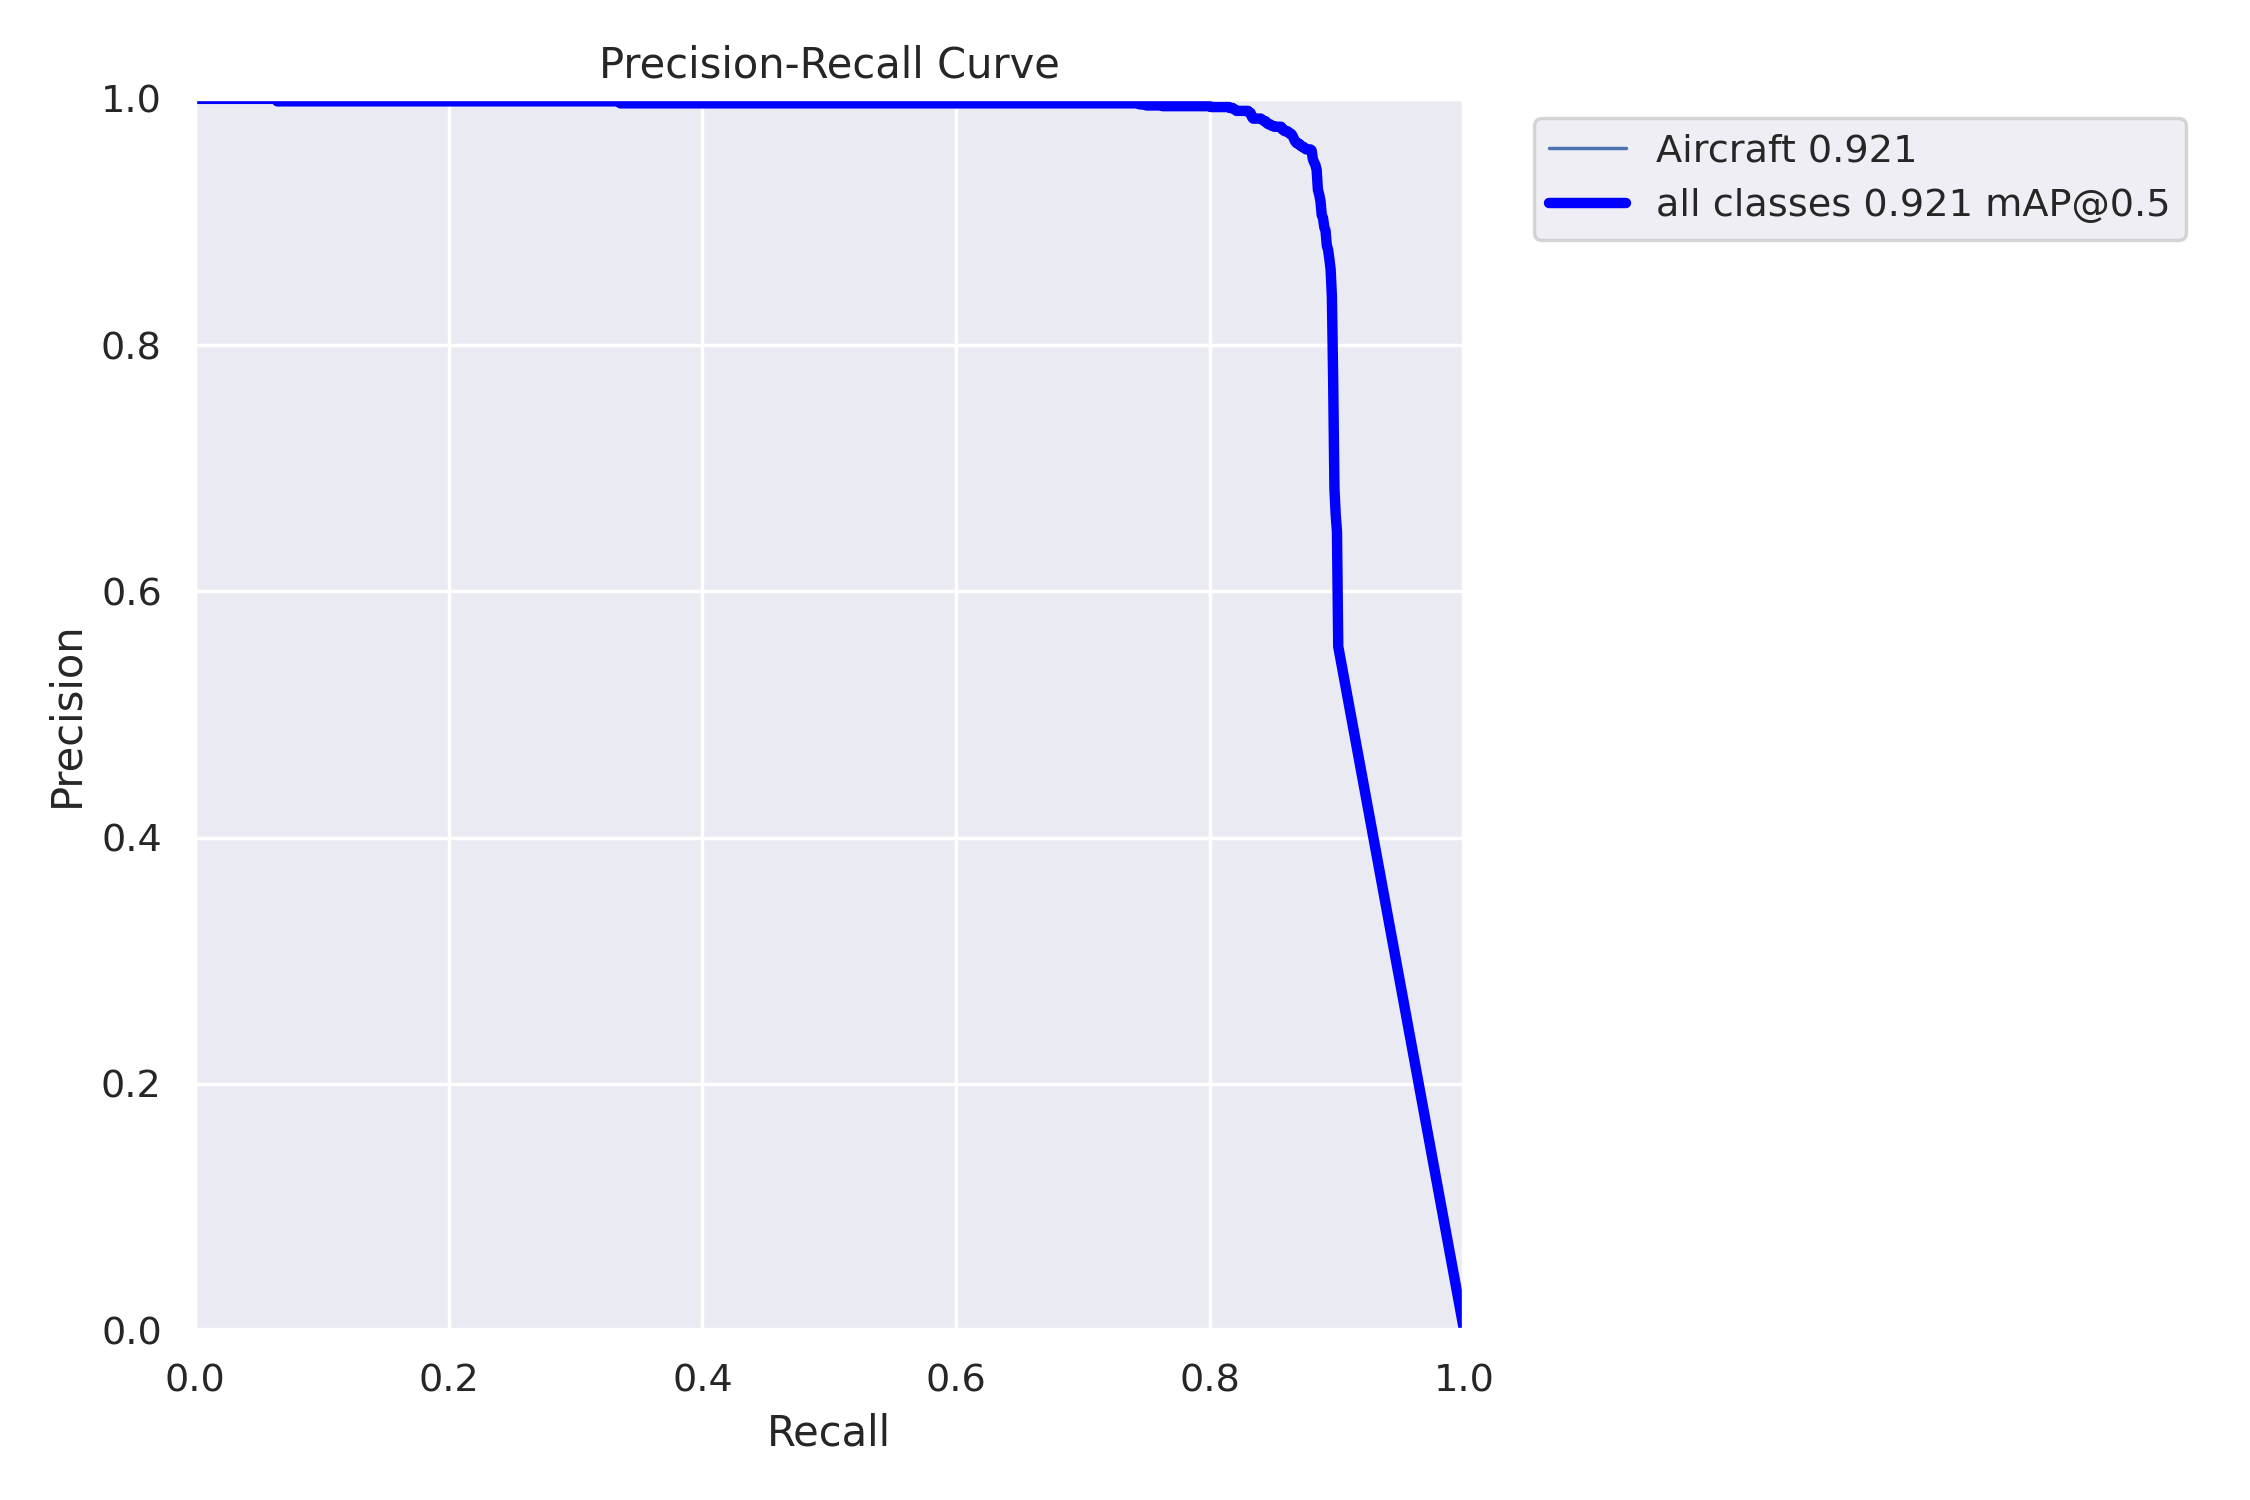

In [ ]:
'''
위 코드는 matplotlib 패키지를 이용해서 저장한 PR_curve.png 파일을 출력하는 코드입니다. 
display.Image() 함수를 이용해 출력되는 이미지 파일의 경로를 지정하고, 이를 출력합니다. 
이를 통해 YOLO 모델의 성능을 시각적으로 확인할 수 있습니다.
'''

display.Image(filename=f'{HOME}/runs/detect/train/PR_curve.png', width=600)


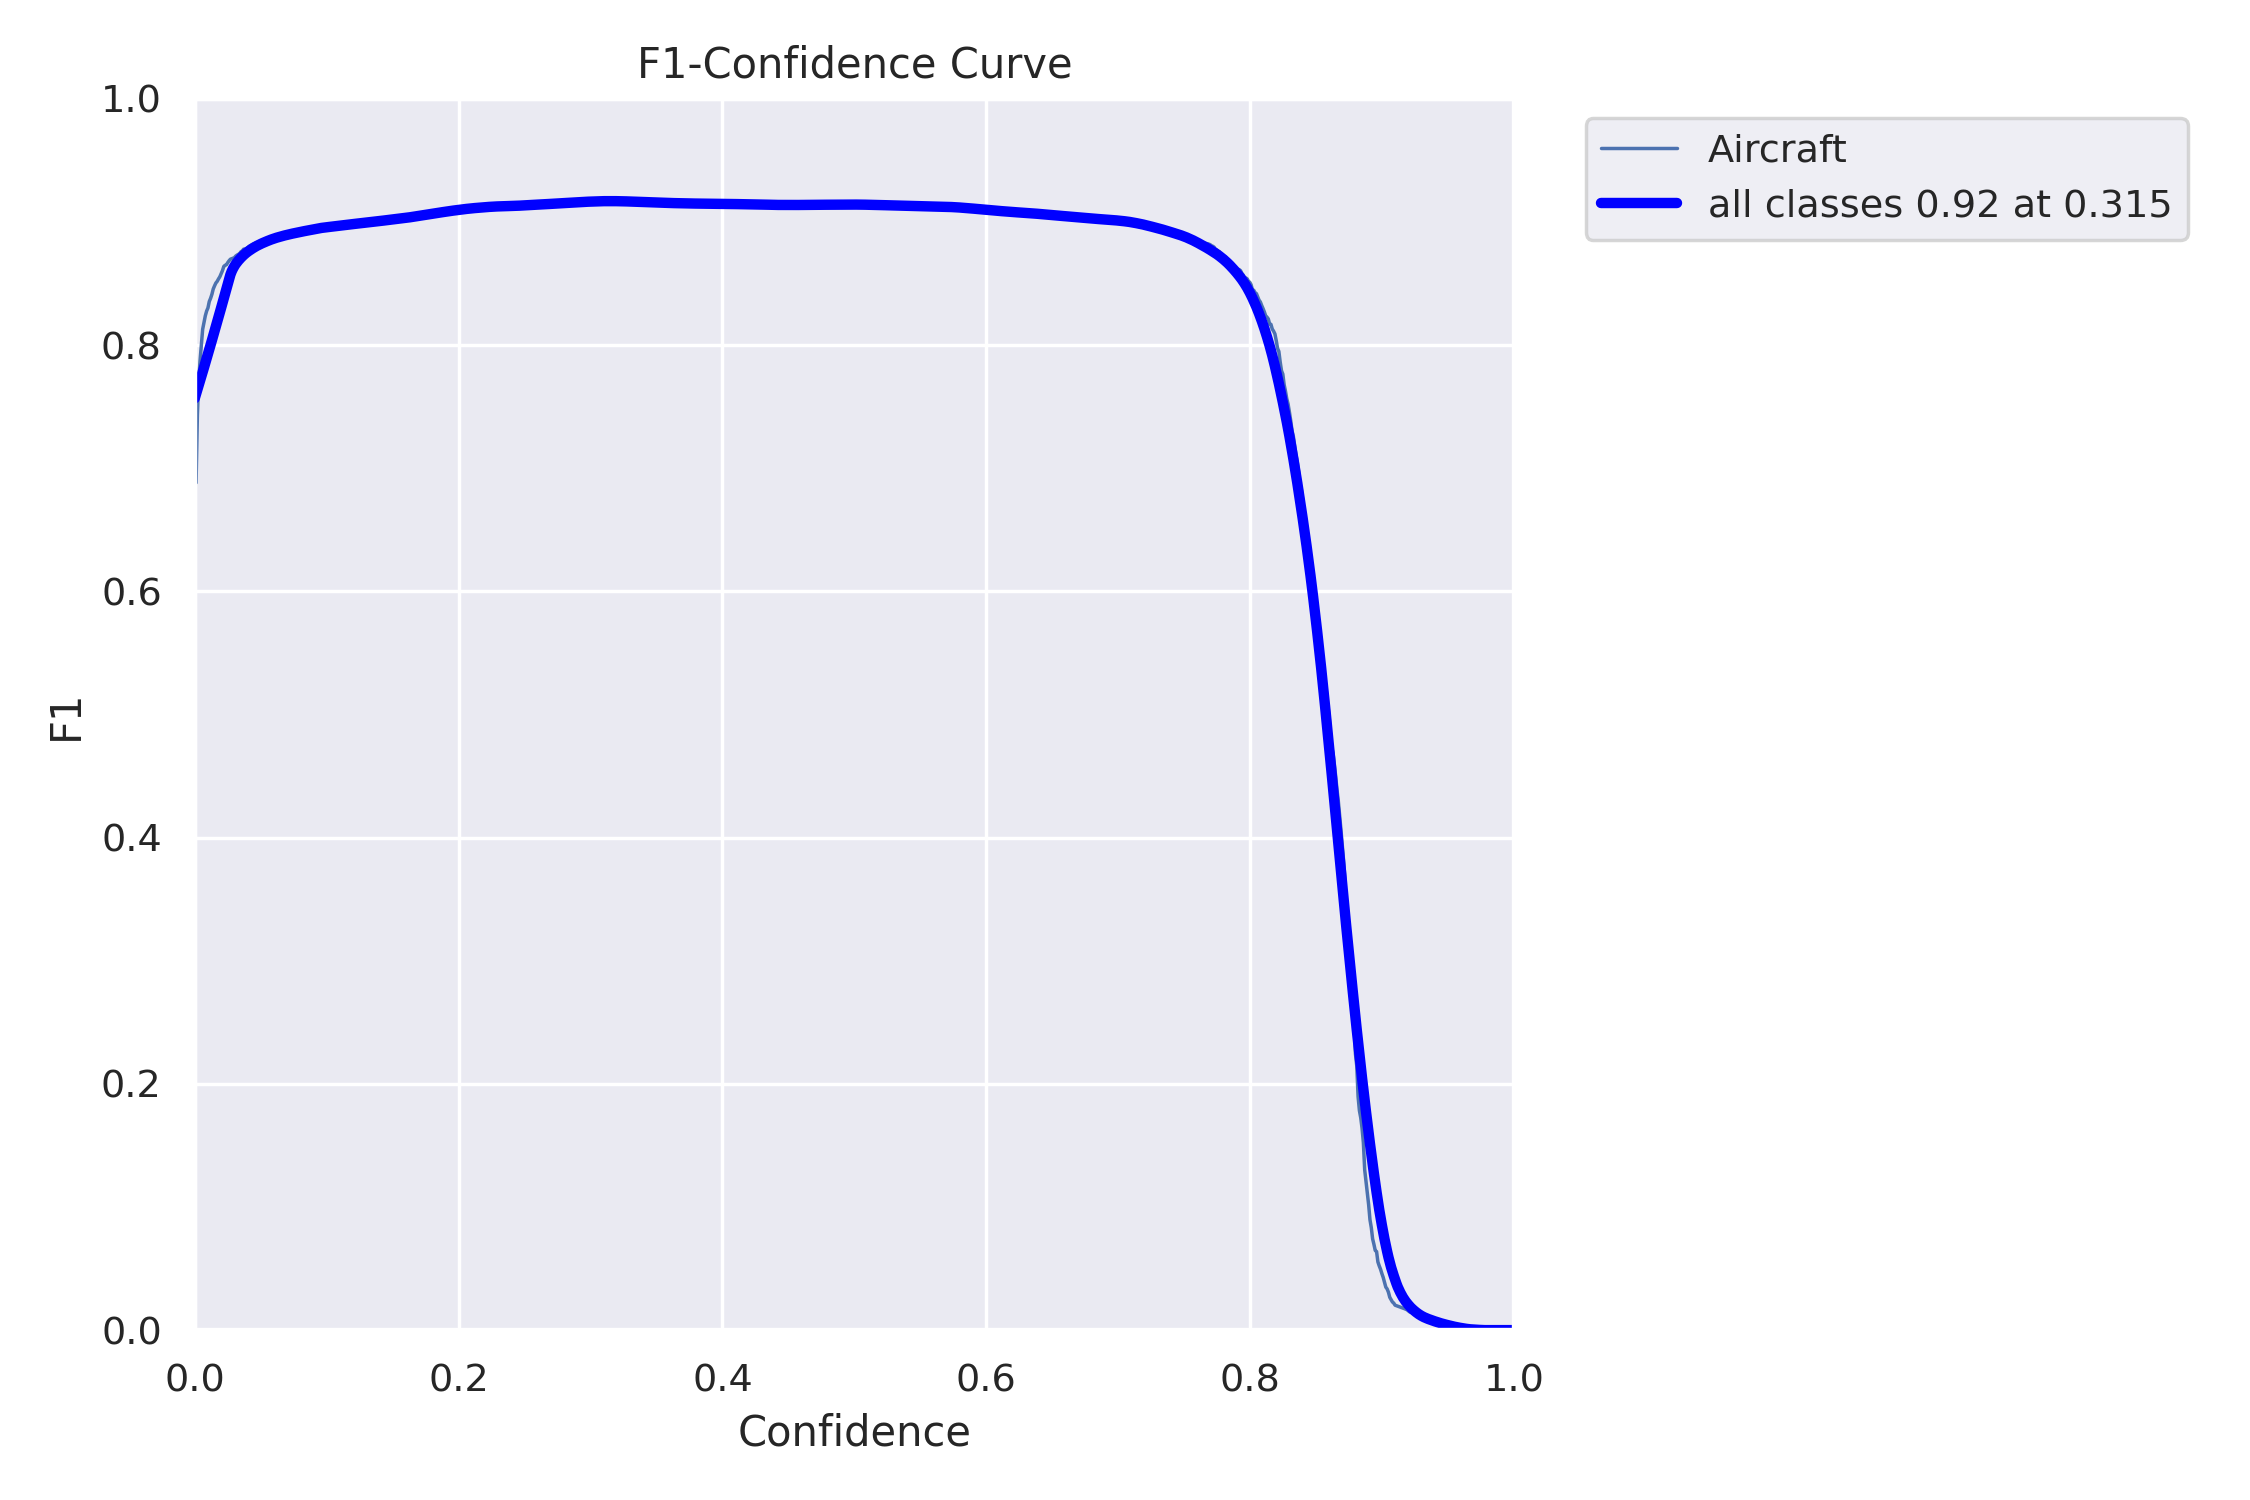

In [ ]:
'''
이 코드는 학습된 모델의 F1 score를 나타내는 그래프를 출력합니다. 
위에서 사용한 코드와 유사하게, display 모듈을 사용하여 이미지 파일을 노트북 셀에 출력합니다. 
filename 인자에는 출력하고자 하는 이미지 파일의 경로를 지정합니다. 
이 경우, F1_curve.png 파일이 HOME 디렉토리 아래 runs/detect/train/ 경로에 있으므로, 해당 경로를 포함한 전체 파일 경로를 지정합니다. 
width 인자는 출력되는 이미지의 가로 크기를 지정합니다.
'''

display.Image(filename=f'{HOME}/runs/detect/train/F1_curve.png', width=600)

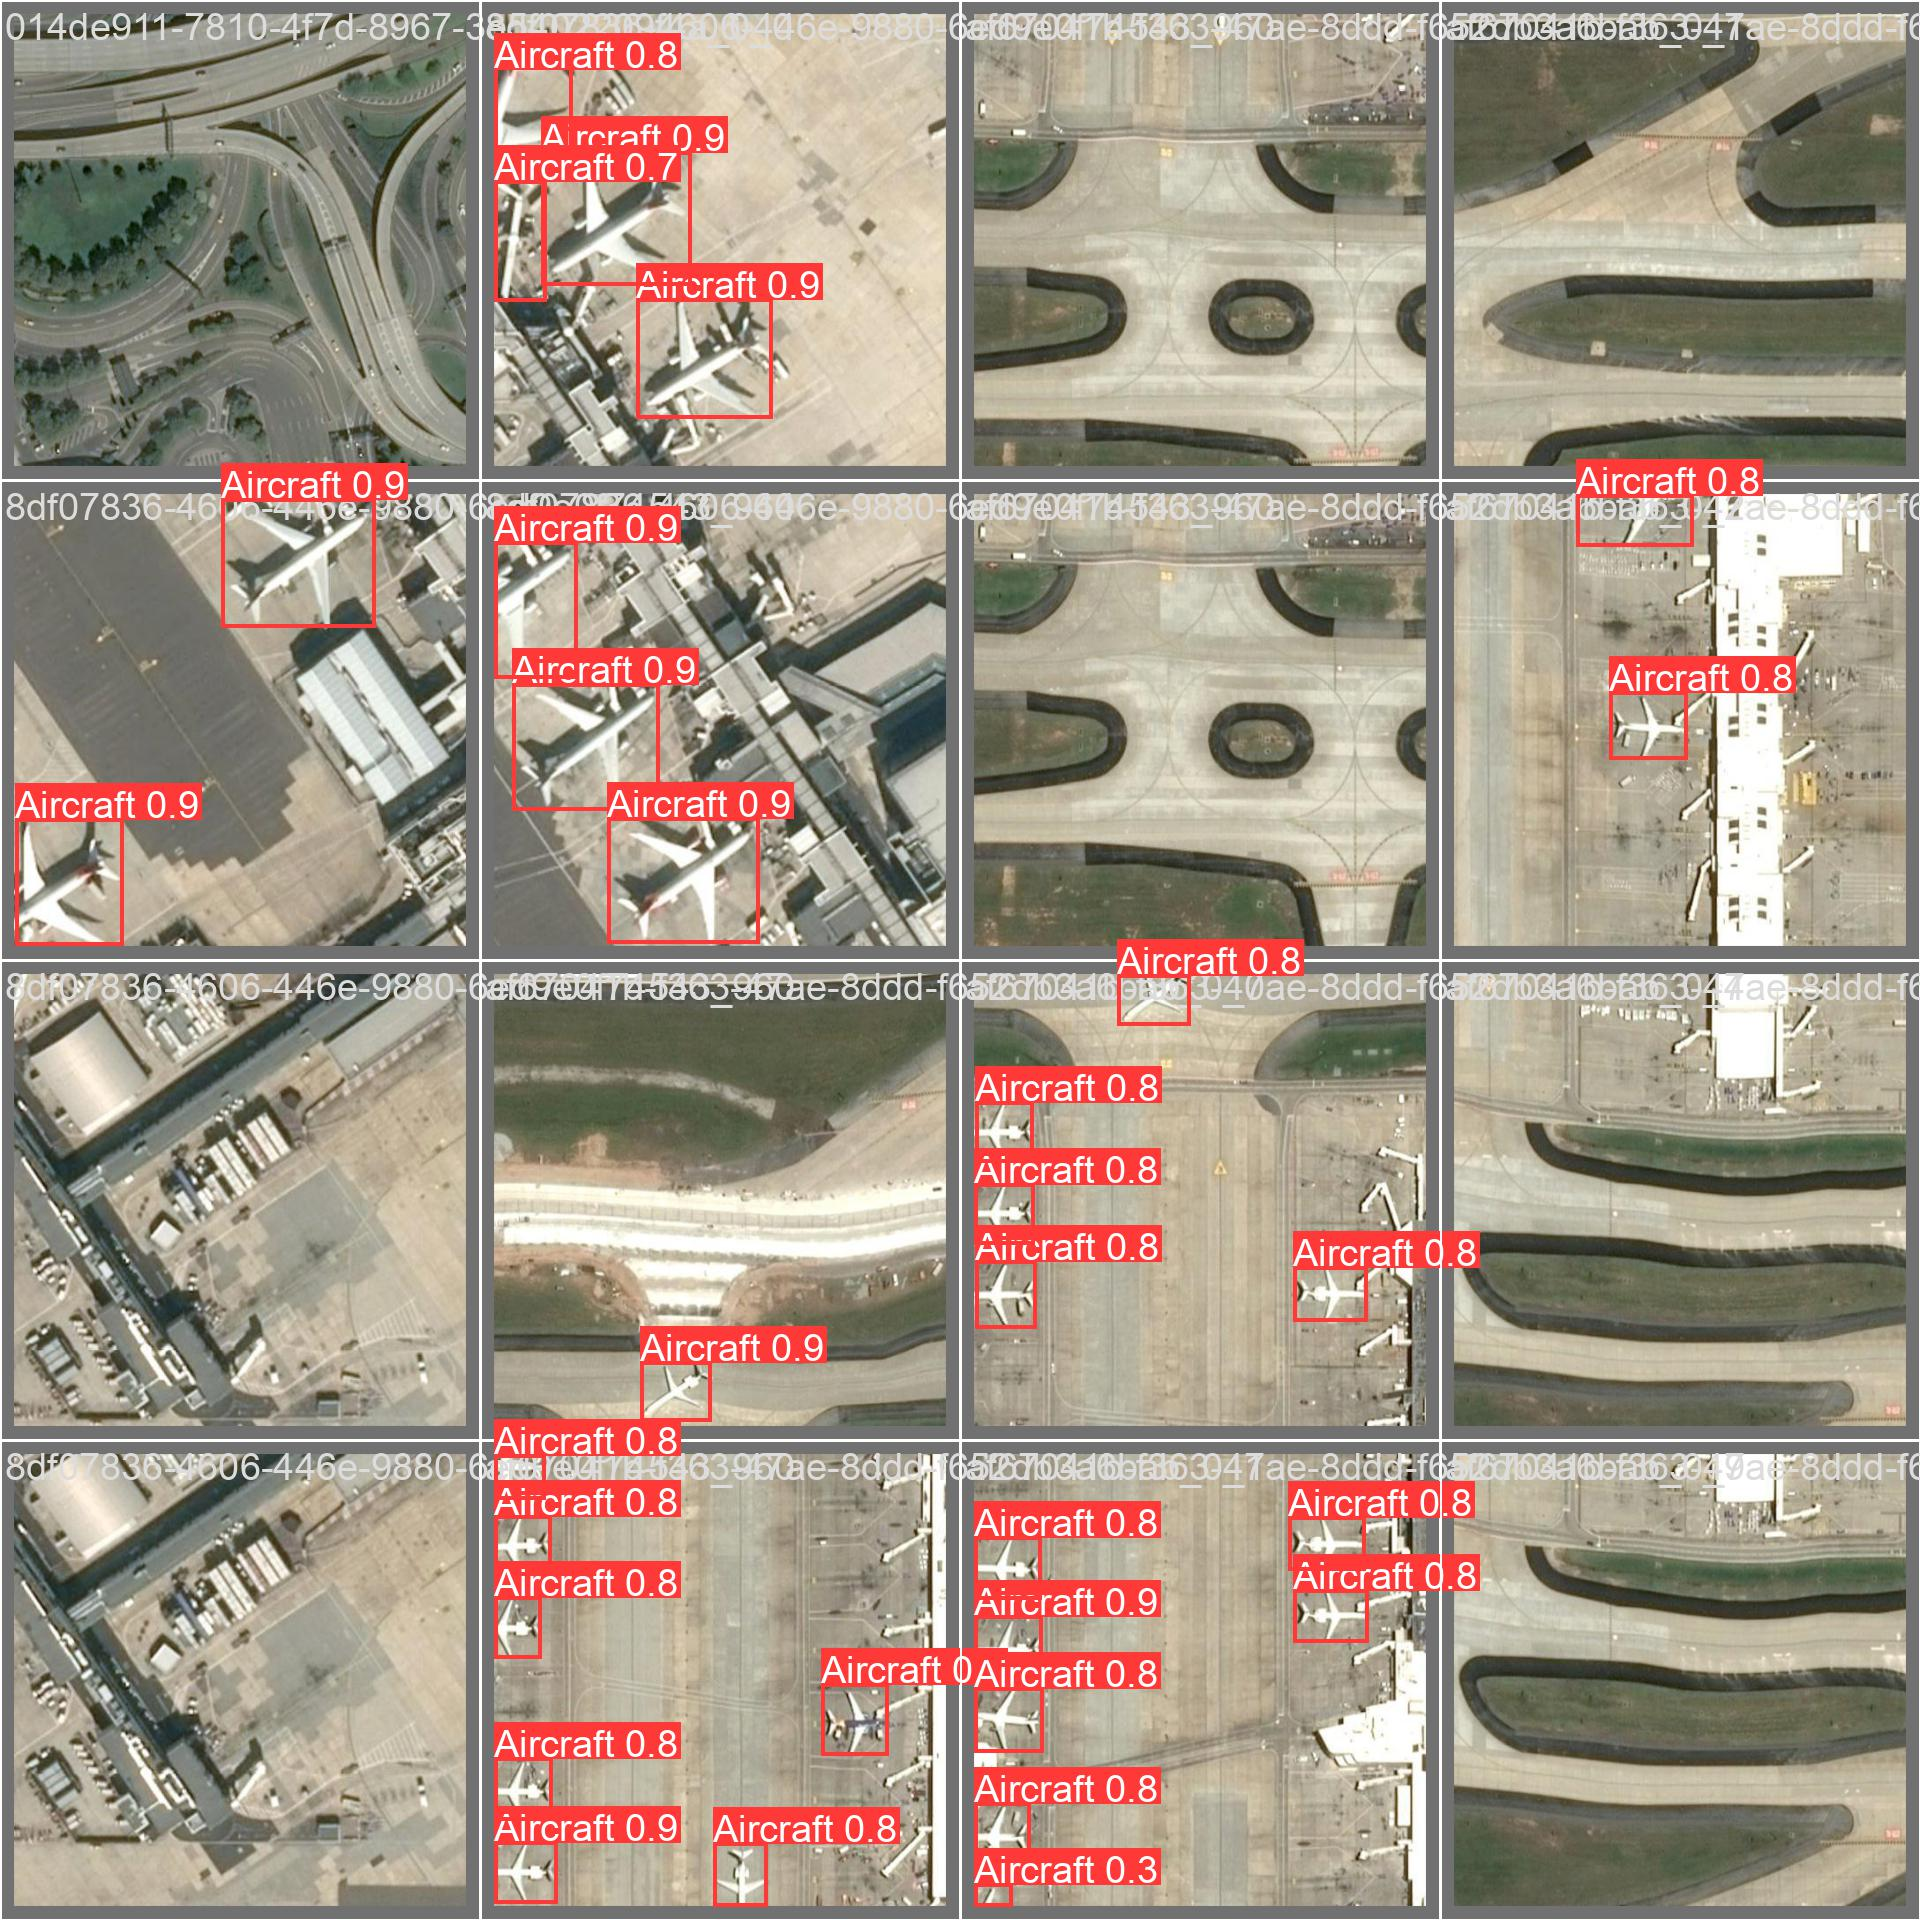

In [ ]:
'''
위 코드는 학습된 YOLO 모델이 예측한 검출 결과 중 하나인 val_batch0_pred.jpg를 출력하는 코드입니다. 
filename 인자에는 이미지 파일의 경로를 지정하고, width 인자에는 출력할 이미지의 너비를 지정합니다. 
출력된 이미지는 Jupyter 노트북 상에서 확인할 수 있습니다.
'''

display.Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=1000)

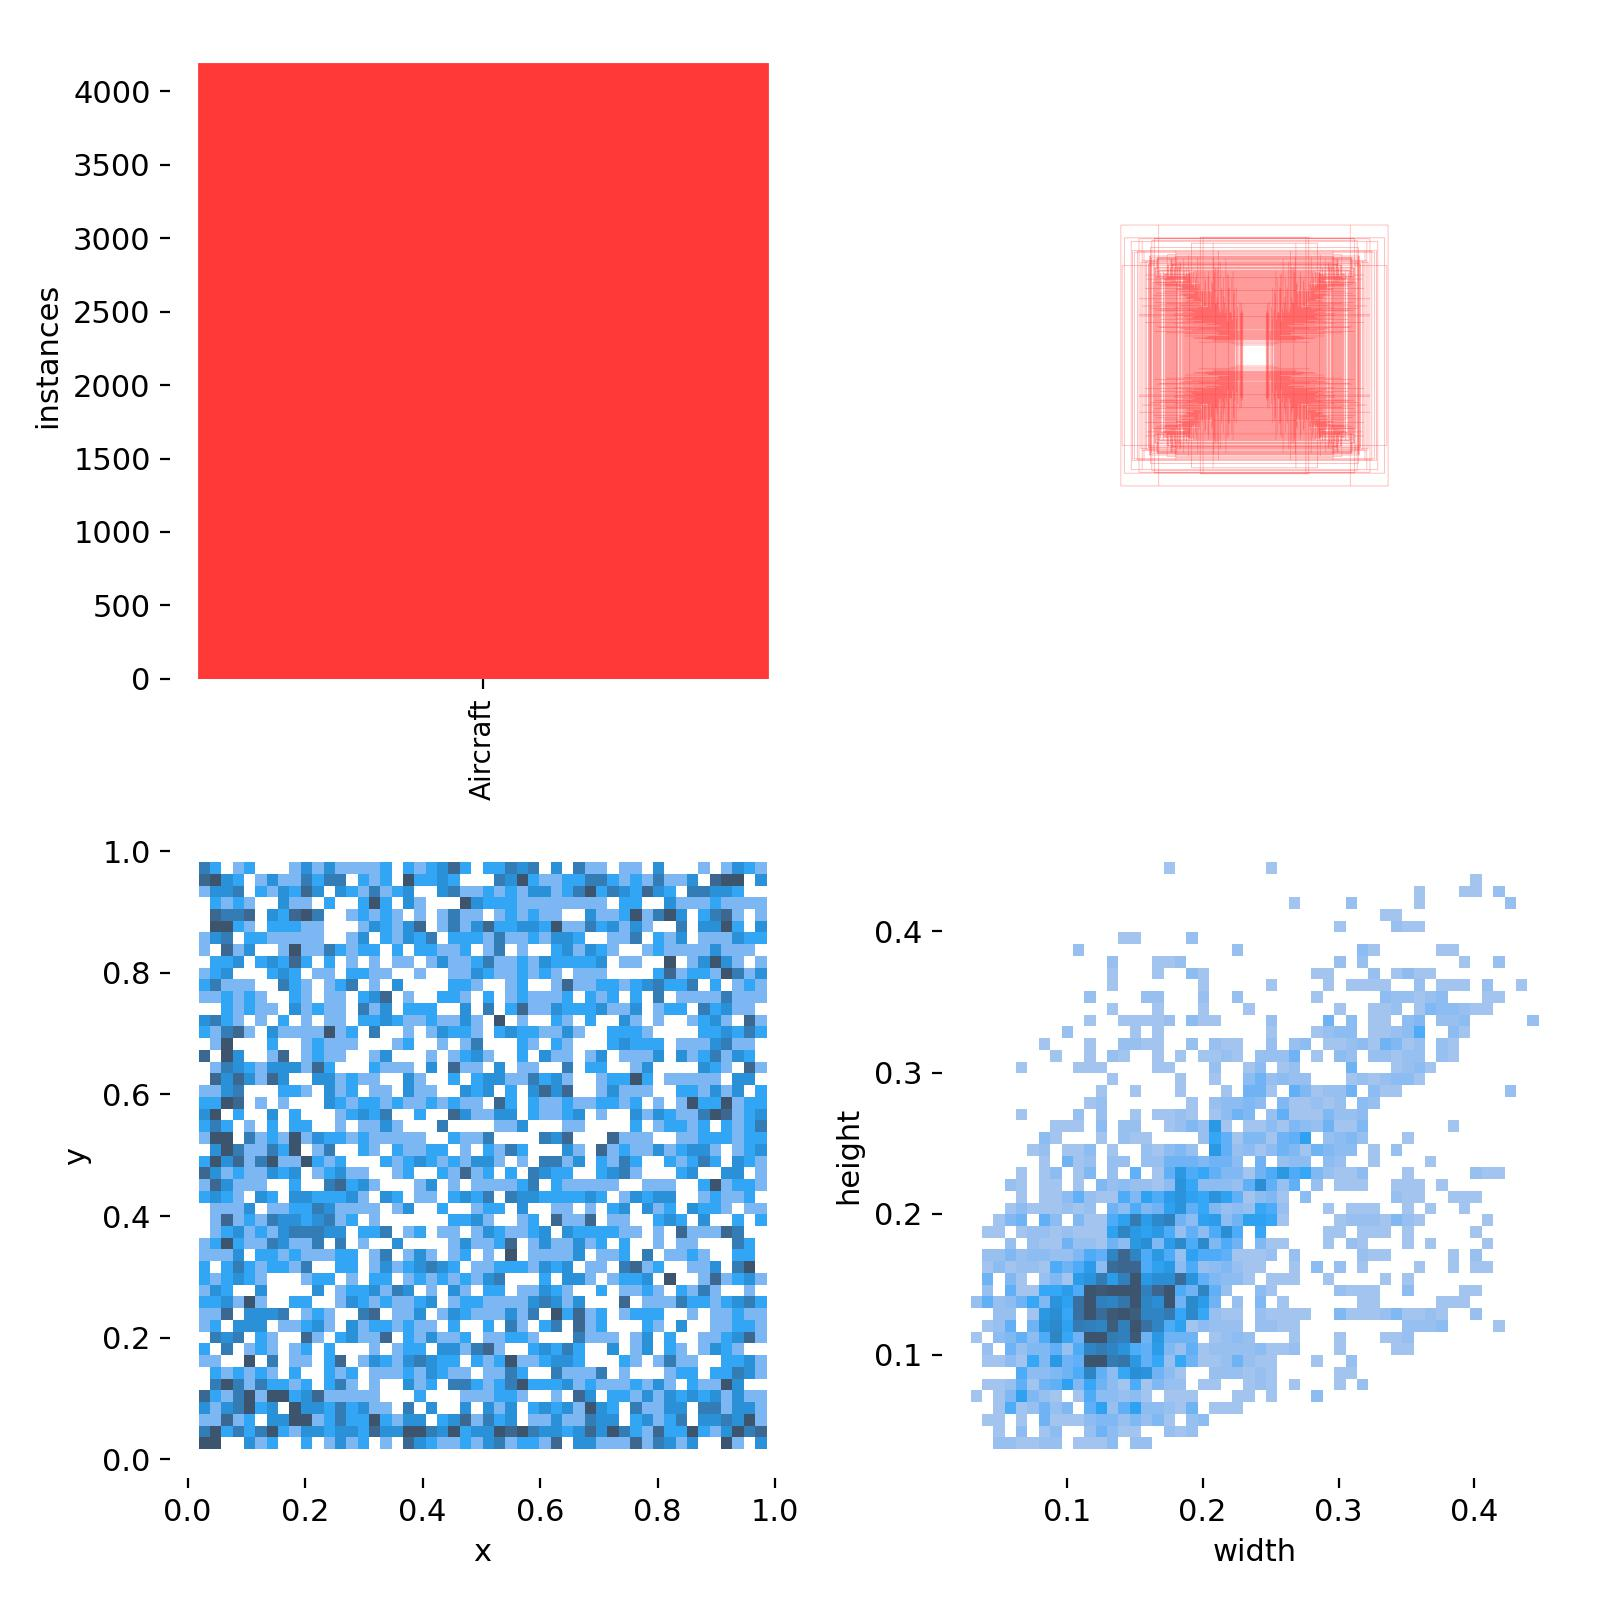

In [ ]:
# predictions on batch 1
Image(filename='/kaggle/working/runs/detect/train/labels.jpg', width=800)

In [ ]:
# we can access all parameters values used for this training
!cat /kaggle/working/runs/detect/train/args.yaml

'''
위 명령어는 YOLO 모델의 detection을 위해 실행된 스크립트의 인자들을 출력하는 명령어입니다.

/kaggle/working/runs/detect/train 폴더에 저장된 args.yaml 파일에는 다음과 같은 정보가 포함됩니다.

weights: 모델 가중치 파일 경로
cfg: 모델 구성 파일 경로
data: 데이터셋 파일 경로
batch-size: 배치 크기
img-size: 입력 이미지 크기
iou-thres: IoU 임계값
conf-thres: confidence 임계값
task: 실행할 작업 (train / detect / val)
name: 출력 결과물의 이름
device: 사용할 디바이스 (cpu / cuda) 등의 정보가 포함됩니다.
'''

task: detect
mode: train
model: yolov8s.pt
data: /kaggle/working/data.yaml
epochs: 50
patience: 50
batch: 16
imgsz: 512
save: true
save_period: -1
cache: false
device: null
workers: 8
project: null
name: null
exist_ok: false
pretrained: false
optimizer: SGD
verbose: true
seed: 0
deterministic: true
single_cls: false
image_weights: false
rect: false
cos_lr: false
close_mosaic: 10
resume: false
overlap_mask: true
mask_ratio: 4
dropout: 0.0
val: true
split: val
save_json: false
save_hybrid: false
conf: null
iou: 0.7
max_det: 300
half: false
dnn: false
plots: true
source: null
show: false
save_txt: false
save_conf: false
save_crop: false
hide_labels: false
hide_conf: false
vid_stride: 1
line_thickness: 3
visualize: false
augment: false
agnostic_nms: false
classes: null
retina_masks: false
boxes: true
format: torchscript
keras: false
optimize: false
int8: false
dynamic: false
simplify: false
opset: null
workspace: 4
nms: false
lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_

'\n위 명령어는 YOLO 모델의 detection을 위해 실행된 스크립트의 인자들을 출력하는 명령어입니다.\n\n/kaggle/working/runs/detect/train 폴더에 저장된 args.yaml 파일에는 다음과 같은 정보가 포함됩니다.\n\nweights: 모델 가중치 파일 경로\ncfg: 모델 구성 파일 경로\ndata: 데이터셋 파일 경로\nbatch-size: 배치 크기\nimg-size: 입력 이미지 크기\niou-thres: IoU 임계값\nconf-thres: confidence 임계값\ntask: 실행할 작업 (train / detect / val)\nname: 출력 결과물의 이름\ndevice: 사용할 디바이스 (cpu / cuda) 등의 정보가 포함됩니다.\n'

##Testing the model


In [ ]:
'''
아래 명령어는 검증 데이터셋을 이용하여 모델의 성능을 평가하는 명령어입니다. 
detect은 검출을 수행하는 태스크(task)를 의미하며, val은 검증 데이터셋을 사용하여 모델의 성능을 평가하는 모드(mode)를 의미합니다. 
model 인자에는 검증 과정에서 가장 좋은 성능을 보인 모델 가중치 파일의 경로를 지정합니다. data 인자에는 모델 학습에 사용한 데이터셋 설정 파일(data.yaml)의 경로를 지정합니다.

즉, 아래 명령어는 검증 데이터셋에 대해 모델을 실행하여, 검출 결과와 성능 평가 결과를 출력하는 것입니다.
'''

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={HOME}/data.yaml

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /kaggle/working/val/labels.cache... 756 images, 273 backgrounds, 0 corrupt: 100% 756/756 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 48/48 [00:06<00:00,  7.59it/s]
                   all        756       1459      0.958      0.879      0.921      0.682
Speed: 0.3ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


아래 코드는 테스트 데이터셋을 위한 data.yaml 파일을 생성하는 코드입니다. train과 val 경로가 각각 학습 데이터셋 경로와 테스트 데이터셋 경로를 지정하고, nc는 클래스 개수, names는 클래스 이름을 설정합니다. 생성된 test.yaml 파일은 이후 YOLO 모델을 테스트할 때 사용됩니다.

In [ ]:
CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: /kaggle/working/train/
val: ../input/airbus-aircraft-test-dataset/test/

# number of classes
nc: 1

# class names
names: ['aircraft']
"""

with open("test.yaml", "w") as f:
    f.write(CONFIG)

In [ ]:
'''
아래 명령어는 작성된 YOLO 모델을 사용하여 테스트 데이터셋에서 객체 검출 작업을 수행합니다.

-- task=detect: YOLOv5를 object detection에 사용합니다.
-- mode=val: 검증 데이터 세트에서 object detection을 수행합니다.
-- model={HOME}/runs/detect/train/weights/best.pt: 저장된 모델 가중치 파일 경로를 나타냅니다.
-- data={HOME}/test.yaml: 데이터셋에 대한 YAML 파일 경로를 제공합니다.
-- imgsz=2560: 이미지 사이즈를 나타냅니다. (이미지 사이즈는 모델 훈련 중 선택된 이미지 사이즈와 동일해야 합니다.)

아래 명령어를 실행하면, 테스트 데이터에서 객체 검출 작업이 수행되며, 각 이미지에서 검출된 객체와 예측된 클래스, confidence score 등을 나타내는 결과가 출력됩니다.
'''
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={HOME}/test.yaml imgsz=2560

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.9/dist-packages/ultralytics/yolo/cfg/__init__.py", line 317, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/usr/local/lib/python3.9/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/ultralytics/yolo/engine/model.py", line 256, in val
    validator(model=self.model)
  File "/usr/local/lib/python3.9/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/ultralytics/yolo/engine/validator.py", line 126, in __call__
    self.data = che

In [ ]:
'''
해당 명령어는 입력된 폴더 내의 이미지들을 대상으로, best.pt 모델을 사용하여 객체 탐지(predict)를 수행합니다. 

-- task=detect: YOLO의 detection task를 수행하도록 설정
-- mode=predict: 모델을 prediction mode로 설정
-- model={HOME}/runs/detect/train/weights/best.pt: 테스트할 모델의 경로와 이름을 설정
-- conf=0.4: confidence threshold를 0.5로 설정하여 높은 확률로 예측되는 물체들만 출력하도록 함
   conf 옵션은 검출된 객체들의 최소 confidence 임계값으로 설정되어 있습니다. 
-- source={DATA_DIR}/extras/: 예측할 이미지들이 있는 폴더의 경로를 설정
-- imgsz=2560: 입력 이미지의 크기를 2560x2560으로 설정하여 이미지를 고해상도로 처리하도록 함.

'''
#!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.5 source={DATA_DIR}/extras/ imgsz=2560
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.5 source={DATA_DIR}/extras/ imgsz=2560 save=True

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

image 1/6 /content/drive/MyDrive/airbus-aircrafts-sample-dataset/extras/022f91f0-1434-401f-a11b-e315b7068100.jpg: 2560x2560 26 Aircrafts, 17.7ms
image 2/6 /content/drive/MyDrive/airbus-aircrafts-sample-dataset/extras/08a8132a-a6c7-4cab-adee-7e2976fd2822.jpg: 2560x2560 29 Aircrafts, 17.7ms
image 3/6 /content/drive/MyDrive/airbus-aircrafts-sample-dataset/extras/22bc9d20-02c4-4554-8fed-2c127d54b5ed.jpg: 2560x2560 30 Aircrafts, 18.0ms
image 4/6 /content/drive/MyDrive/airbus-aircrafts-sample-dataset/extras/55aa185a-01c8-4668-ae87-1f1d67d15a08.jpg: 2560x2560 29 Aircrafts, 30.4ms
image 5/6 /content/drive/MyDrive/airbus-aircrafts-sample-dataset/extras/65825eef-f8a1-41b3-ac87-4a0a7d482a0e.jpg: 2560x2560 20 Aircrafts, 17.6ms
image 6/6 /content/drive/MyDrive/airbus-aircrafts-sample-dataset/extras/defbf838-828b-4427-9b

In [ ]:
'''
해당 코드는 detect 모드로 실행된 모델의 결과로 생성된 예측 이미지들을 출력해주는 코드입니다.

glob 라이브러리를 사용하여 특정 경로 내에 있는 모든 jpg 파일의 경로를 찾아냅니다. 

그리고 Image 클래스를 이용하여 이미지 파일을 읽어와서 Jupyter 노트북에서 이미지를 출력합니다.

print("\n") 코드는 각 이미지 출력 후에 빈 줄을 하나씩 추가하여 가독성을 높이는 역할을 합니다.
'''

import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg'):
      display(Image(filename=image_path, width=1024))
      print("\n")